# Fairness In AI

In this practical session we will focus on ways to measure models fairness as well as introducing some synthetic way to generate images. The first part is focused on generation through DCGAN, then with a diffusion model approach and finally we'll see the impact of datset balancing on performances in Face Recognition. We will focus on demographic biases during this session. In order to study these biases we will use FairFace during this practical as well as the FavCI2D dataset in order to classify the images.

In [ ]:
#%matplotlib inline
!pip install dlib
!pip install pytorch_lightning
import argparse
import pytorch_lightning as pl
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import torchvision
from pytorch_lightning import seed_everything
import torchmetrics
from pytorch_lightning.loggers import CSVLogger

def flatten_paths_recursively(root_path:str, output_absolute_path:bool=False, depth: "int|None" = None, exclusion_list:'list[str]' = [], keep_dir=False, parent_folder=None):
    """
    return the list of the paths of all the file contained in root_path
    INPUT:
    - root_path
    - output_absolute_path : if set to True, will store the absolute path
    - depth : if not None will stop the elts search at the given step
    - exclusion_list : will ignore the files whose name repsect the regexp stored
    - keep_dir : keep dir within returned list
    """
    result = []
    if os.path.isfile(root_path) or(not(depth is None) and depth == 0 ):
        if output_absolute_path:
            return [os.path.abspath(root_path)]
        return [os.path.relpath(root_path, parent_folder)]

    root_path = format_prepath(root_path)
    if parent_folder is None:
        print("getting all paths")
        iterator = tqdm(os.listdir(root_path))
        parent_folder = root_path
    else:
        iterator = os.listdir(root_path)
    if keep_dir:
        result.append(root_path[:-1])
    for elt in iterator:
        elt_path = root_path + elt
        result += flatten_paths_recursively(elt_path, output_absolute_path, None if depth is None else depth - 1, exclusion_list=exclusion_list, keep_dir=keep_dir, parent_folder=parent_folder)
    return result

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 61.1 MB/s eta 0:00:00


In [ ]:
# 授权访问colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget https://cdn.matix-media.net/dd/bddee0d2 -O celeba.zip
# !unzip -q celeba.zip
!wget https://cdn.matix-media.net/dd/bddee0d2 -O /content/drive/MyDrive/celeba.zip


--2024-02-19 11:53:48--  https://cdn.matix-media.net/dd/bddee0d2
Resolving cdn.matix-media.net (cdn.matix-media.net)... 172.67.135.197, 104.21.7.52, 2606:4700:3035::ac43:87c5, ...
Connecting to cdn.matix-media.net (cdn.matix-media.net)|172.67.135.197|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdll4TDRzNmVGTEVpUEo3MkNoQjFzS09lVzUweWc_ZT1LcjN6V0w/root/content [following]
--2024-02-19 11:53:49--  https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdll4TDRzNmVGTEVpUEo3MkNoQjFzS09lVzUweWc_ZT1LcjN6V0w/root/content
Resolving api.onedrive.com (api.onedrive.com)... 13.107.42.12
Connecting to api.onedrive.com (api.onedrive.com)|13.107.42.12|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dnnntw.db.files.1drv.com/y4mZ-PO3h5zuYb2aR8FYE0OaWbcQhKaoccQTApqk8SwADpWCmtF5KRgE_cOaefdoU-nt_OEnVJJ1--v0q7beu4BLgZIgTHNI_dO0QUmN150OSH56gBdmDE0RfhPKF72x5Y8k

In [ ]:

!unzip -q /content/drive/MyDrive/celeba.zip -d /content/celeba

## Data stuff

In [ ]:
class CelebaSet:
    def __init__(self,imgs_path, transform):
        self.imgs_path = imgs_path
        self.transform = transform

    def __getitem__(self, i):
        image = Image.open(self.imgs_path[i])
        return self.transform(image)
    def __len__(self):
        return len(self.imgs_path)

In [ ]:
class CelebaModule(pl.LightningDataModule):
    def __init__(self, imgs_root, num_workers = 10, batch_size=128, image_size =64):
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.image_size = image_size

        self.imgs_root = imgs_root
        content = os.listdir(imgs_root)
        if os.path.isdir(content[0]):
            imgs = flatten_paths_recursively
        else:
            imgs = os.listdir(imgs_root)
        self.imgs = [os.path.join(imgs_root, img) for img in imgs]

        self.transform=transforms.Compose([
                               transforms.Resize((self.image_size, self.image_size)),
                               # transforms.CenterCrop(self.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
    def setup(self, stage=None):
        # Split the data into train, val and test sets
        train_len = int(len(self.imgs) * 0.8)
        val_len = len(self.imgs) - train_len
        train_set, val_set = torch.utils.data.random_split(self.imgs, [train_len, val_len])
        self.train_set = CelebaSet(train_set, self.transform)
        self.val_set = CelebaSet(val_set, self.transform)

    def train_dataloader(self):
        # Return the train dataloader
        return torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers )

    def val_dataloader(self):
        # Return the val dataloader
        return torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)




In [ ]:
# Root directory for dataset
dataroot = "celeba/img_align_celeba"

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
batch_size = 64
image_size = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
workers=10

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


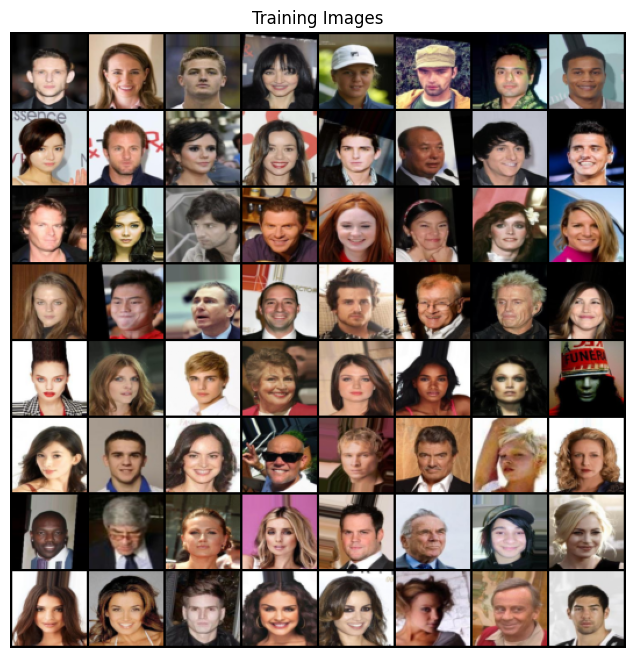

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size, image_size = image_size, num_workers=workers)
data_module.setup()
# Create the dataloader
dataloader = data_module.train_dataloader()

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Model stuff

In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class BasicGeneratorBlock(nn.Module):
    """ BasicBlock for DCGAn
    """
    def __init__(self, nb_features_in, nn_features_out, kernel_size, stride=1, padding=0, shortcut=None, anchor = False):
        super(BasicGeneratorBlock, self).__init__()
        if shortcut is not None:
            self.shortcut_layer = shorcut
        else:
            self.shortcut_layer = lambda x, res: torch.zeros_like(res, device=x.device)
        self.res_layer = nn.Sequential(
            nn.ConvTranspose2d( nb_features_in, nn_features_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(nn_features_out),
            nn.ReLU(True))

    def forward(self, x):

        res = self.res_layer(x)
        shortcut = self.shortcut_layer(x, res)
        return shortcut + res



In [ ]:
def test(args1, args2):
    print("args1: ", args1)
    print("args2: ", args2)

In [ ]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngf, nz, nc, depth = 4):
        super(Generator, self).__init__()
        kernel_size = depth // 4 * 4
        layers = [BasicGeneratorBlock(nz, ngf *  2**(depth - 1), kernel_size, 1, 0)]
        for i in range(depth - 1, 0, -1):
            if (depth - i) % 4 == 0:
                kernel_size = max(4, kernel_size // 2)
            layers.append(BasicGeneratorBlock(ngf *  2**(i), ngf *  2**(i-1), kernel_size, 2, 1))

        layers.append(nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)


    def forward(self, input):
        return self.main(input)

In [ ]:
class BasicDiscriminatorBlock(nn.Module):
    """
    BasicBlock for DCGAn
    """
    def __init__(self, nb_features_in, nn_features_out, kernel_size, stride=2, padding=0, shortcut=None, anchor = False):
        super(BasicDiscriminatorBlock, self).__init__()
        if shortcut is not None:
            self.shortcut_layer = shorcut
        else:
            self.shortcut_layer = lambda x, res: torch.zeros_like(res, device=x.device)
        self.res_layer = nn.Sequential(
            nn.Conv2d(nb_features_in, nn_features_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(nn_features_out),
            nn.LeakyReLU(0.2, inplace=True))


    def forward(self, x):
        res = self.res_layer(x)
        shortcut = self.shortcut_layer(x, res)

        return shortcut + res


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nc, depth = 4):
        super(Discriminator, self).__init__()
        kernel_size = depth // 4 * 4
        layers = [nn.Conv2d(nc, ndf, kernel_size, 2, 1, bias=False),nn.LeakyReLU(0.2, inplace=True)]

        for i in range(0, depth - 1):
            if i % 4 == 0:
                kernel_size = max(4, kernel_size // 2)
            layers.append(BasicDiscriminatorBlock(ndf *  2**(i), ndf *  2**(i+1), kernel_size, 2, 1))

        layers.append(nn.Conv2d(ndf * 2**(depth - 1), 1, 4, 1, 0, bias=False))
        layers.append(nn.Sigmoid())
        self.main = nn.Sequential(*layers)

    def forward(self, input):
        return self.main(input).squeeze()

In [ ]:
import gc
class DCGANTrain(pl.LightningModule):
    def __init__(self, learning_rate=0.0002, beta1 =0.5,  nc=3, ngf=64, nz=100, ndf=64, depth=4, generator_inner_repetition=1,device = "cuda" if torch.cuda.is_available() else "cpu", images_folder = "images_logs"):
        super().__init__()
        self.generator_inner_repetition = generator_inner_repetition
        self.nz = nz
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.netG = Generator(ngf, nz, nc, depth).to(self.device)
        self.netG.apply(weights_init)
        self.netD = Discriminator(ndf, nc, depth).to(self.device)
        self.netD.apply(weights_init)
        self.learning_rate = learning_rate

        self.criterion = nn.BCELoss().to(device) # TO BE COMPLETED

        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2)
        os.makedirs(images_folder, exist_ok=True)
        self.image_logs = os.path.join(images_folder, f"training_{len(os.listdir(images_folder)) + 1}" )
        os.makedirs(self.image_logs)

    def forward(self, nb_images= 1, convert_to_image = False ):
        with torch.no_grad():
            tensors = self.netG(torch.randn(nb_images, self.nz, 1, 1, device=self.device))
            return_images = []
            for tensor in tensors:
                correct_range_tensor = (tensor - tensor.min())/ (tensor.max() - tensor.min()).detach().cpu()
                if convert_to_image:
                    correct_range_tensor = transforms.ToPILImage()(correct_range_tensor)
                return_images.append(correct_range_tensor)
            return return_images

    def training_step(self, real_images):
        ## Otpimize Discriminator

        accuracy_fake = 0
        z = torch.randn(len(real_images), self.nz, 1, 1, device=self.device)
        self.netD.zero_grad()
        self.netG.zero_grad()

        # COMPUTE DISCRIMINATOR LOSS ON FAKE SAMPLES
        fake_images = self.netG(z)
        fake_labels = torch.zeros(len(real_images),  device=self.device)
        fake_output = self.netD(fake_images.detach()).view(-1)
        LossFake = self.criterion(fake_output, fake_labels) # TO BE COMPLETED
        LossFake.backward()

        # COMPUTE DISCRIMINATOR LOSS ON REAL SAMPLES
        real_labels = torch.ones(len(real_images),  device=self.device)
        real_output = self.netD(real_images).view(-1)
        LossReal = self.criterion(real_output, real_labels)# TO BE COMPLETED
        LossReal.backward()
        self.optimizerD.step()


        DLoss = LossReal.item() + LossFake.item()

        self.log('train_discriminator_loss', DLoss, on_step=True, on_epoch=True, logger=True)
        ## Optimize generator

        z2 = torch.randn(len(real_images), self.nz, 1, 1, device=self.device)
        self.netD.zero_grad()
        self.netG.zero_grad()


        output = self.netD(fake_images).view(-1)
        GLoss = self.criterion(output, real_labels)# TO BE COMPLETED
        GLoss.backward()
        self.optimizerG.step()
        self.log("generator acc", accuracy_fake, on_step=True, on_epoch=True, logger=True)
        self.log('train_generator_loss', GLoss, on_step=True, on_epoch=True, logger=True)


    def validation_step(self, real_images):
        z = torch.randn(len(real_images), self.nz, 1, 1, device=self.device)
        fake_images = self.netG(z).detach()

        real_labels = torch.ones(len(real_images), device= self.device)
        fake_labels = torch.zeros(len(real_images), device= self.device)
        labels = torch.cat((real_labels, fake_labels), dim = 0 )
        images = torch.cat((real_images, fake_images), dim = 0)
        netDpreds = self.netD(images)
        fake_preds = netDpreds[-len(real_images):]
        real_preds = netDpreds[:len(real_images)]
        accuracy_fake = self.accuracy(fake_preds, fake_labels)
        accuracy_real = self.accuracy(real_preds, real_labels)

        self.log("val_accuracy_fake_images", accuracy_fake, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_accuracy_real_images", accuracy_real, on_step=False, on_epoch=True, logger=True, prog_bar=True)

        epoch_images = os.path.join(self.image_logs, f"{self.current_epoch}.png")
        if not(os.path.exists(epoch_images)):
            sample_imgs = fake_images
            grid = torchvision.utils.make_grid(sample_imgs, normalize=True)
            torchvision.utils.save_image(grid, epoch_images, normalize=True)


    def on_validation_end(self) -> None:
        gc.collect()
    def configure_optimizers(self):
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))

In [ ]:
seed_everything(42, workers=True)
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size , image_size = image_size, num_workers=workers)
trainModule = DCGANTrain()


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [ ]:
trainer = pl.Trainer(max_epochs=50,logger=[CSVLogger(save_dir="metrics" , name="result")])
trainer.fit(trainModule, data_module)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:181: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | netG      | Generator          | 3.6 M 
1 | netD      | Discriminator      | 2.8 M 
2 | criterion | BCELoss            | 0     
3 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
6.3 M     Trainable params
0         Non-trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | netG      | Generator          | 3.6 M 
1 | netD      | Discriminator      | 2.8 M 
2 | criterion | BCELoss            | 0     
3 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# folder_path = '/content/drive/My Drive/colab_models'
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# model_path = '/content/drive/My Drive/colab_models/my_trained_model.ckpt' # 指定保存路径
# torch.save(trainModule.state_dict(), model_path)

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/colab_models/checkpoints/epoch=49-step=126650.ckpt")["state_dict"]
trainModule.load_state_dict(state_dict)

<All keys matched successfully>

Question 1: Visualize the results and comment their quality. What do think might be done to increase the quality ? Try to do so and try to change the parameters. Do some annoying phenomenon occur, why do you think so ?

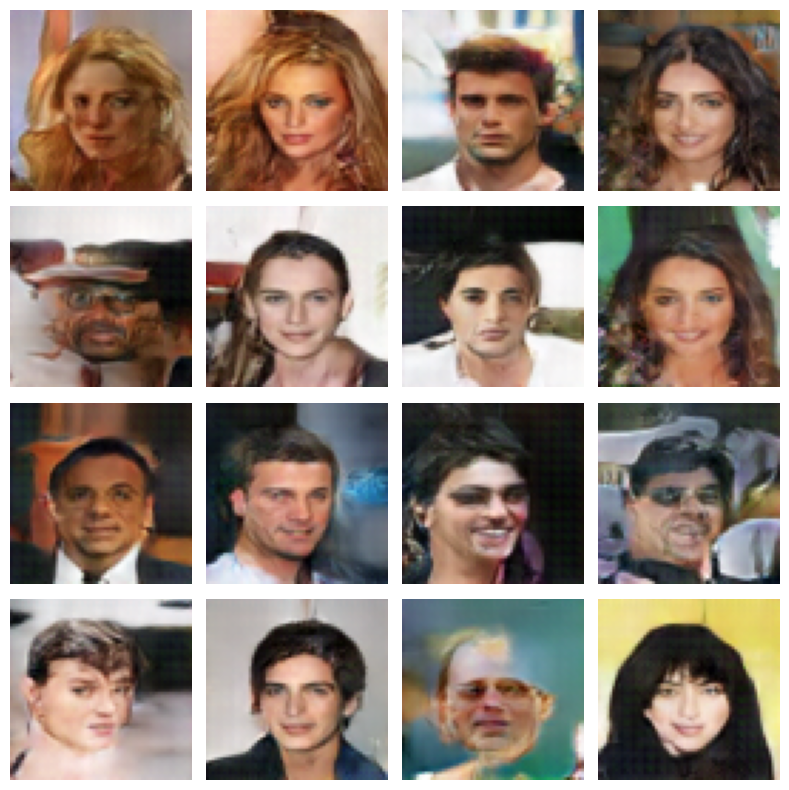

In [ ]:
# Generate some images
generated_images = trainModule.forward(nb_images=16, convert_to_image=True)

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for ax, img in zip(axes.flatten(), generated_images):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

**Answer:**

Generated images don't look like real human faces.

Since training 1 model took me more than 4 hours, I decided not to change the parameters to find the optimal parameters. However, if I have enough time, I'd like to increase the depth, change the kernel sizes of convolutional layers, or change the batch size, and so on.



## Fairface

Now that we can Generate Images, we will study the biases within the synthetic images and compare them to the biases within the training set (i.e. CelebaHQ here). In order to do so we need a way to annotate the pictures.

QUESTION 2: We are using here the FairFace model in order to classify pictures. Check the paper related to theis approach at https://arxiv.org/pdf/1908.04913.pdf . What is your opininon on the images and annotation collection process? What kind of impact (on the performance, ethical etc.. ) could it have ?

In [ ]:

#state_dict = torch.load("/content/drive/My Drive/celeba_checkpoint/epoch=49-step=126650.ckpt")["state_dict"]
#trainModule.load_state_dict(state_dict)
_ = trainModule.eval()

In [ ]:
## Generate lany images
nb_images_to_pick = 200
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size , image_size = image_size, num_workers=workers)
data_module.setup()
fake_images = trainModule(nb_images_to_pick)

rnd_idx = random.sample(list(np.arange(len(data_module.train_set))), nb_images_to_pick)
real_images = [data_module.train_set[i] for i in rnd_idx]

In [ ]:
import os
import torchvision
import torch
import dlib
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import shutil

In [ ]:
!wget https://cdn.matix-media.net/dd/df81c935 -O /content/drive/MyDrive/FairFaceFolder.zip


--2024-02-19 18:48:39--  https://cdn.matix-media.net/dd/df81c935
Resolving cdn.matix-media.net (cdn.matix-media.net)... 172.67.135.197, 104.21.7.52, 2606:4700:3030::6815:734, ...
Connecting to cdn.matix-media.net (cdn.matix-media.net)|172.67.135.197|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdll4TDRzNmVGTEVpUE4yWWh0V0trVVVqNUxOekE_ZT1BNUVKMXA/root/content [following]
--2024-02-19 18:48:39--  https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdll4TDRzNmVGTEVpUE4yWWh0V0trVVVqNUxOekE_ZT1BNUVKMXA/root/content
Resolving api.onedrive.com (api.onedrive.com)... 13.107.42.12
Connecting to api.onedrive.com (api.onedrive.com)|13.107.42.12|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cpgh8g.db.files.1drv.com/y4mGSRT9p365hXdao81041eCWC_6G6PfSiXWOXTxXQFb32ZybbDVBraXf9LsVofvb2ugVc6PHwhzDLYMhFQL0_GZTUc90I_LcSQIqL4O1DcSqs3WvI5ufDM9gDpQpZghtMLOT

In [ ]:
!unzip -q /content/drive/MyDrive/FairFaceFolder.zip -d /content/FairFaceFolder

In [ ]:
os.chdir("FairFaceFolder")

In [ ]:
device="cpu"
## model for gender prediction
model_fair_7 = torchvision.models.resnet34(pretrained=True)
model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
model_fair_7.load_state_dict(torch.load('./FairFaceFolder/res34_fair_align_multi_7_20190809.pt'))
model_fair_7 = model_fair_7.to(device)
_ = model_fair_7.eval()

## model for race prediction
model_fair_4 = torchvision.models.resnet34(pretrained=True)
model_fair_4.fc = nn.Linear(model_fair_4.fc.in_features, 18)
model_fair_4.load_state_dict(torch.load('./FairFaceFolder/res34_fair_align_multi_4_20190809.pt'))
model_fair_4 = model_fair_4.to(device)
_ = model_fair_4.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth

  0%|          | 0.00/83.3M [00:00<?, ?B/s]
 20%|█▉        | 16.4M/83.3M [00:00<00:00, 172MB/s]
 40%|████      | 33.5M/83.3M [00:00<00:00, 176MB/s]
 61%|██████    | 50.7M/83.3M [00:00<00:00, 178MB/s]
100%|██████████| 83.3M/83.3M [00:00<00:00, 

In [ ]:
def predict_gender_and_race(image, model_gender, model_race):
    # imgs_paths = [os.path.join(imgs_path, x) for x in os.listdir(imgs_path)]
    device = "cpu"
    if type(image) is str:
        image = dlib.load_rgb_image(image)



    trans = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    image = trans(image)
    image = image.view(1, 3, 224, 224)  # reshape image to match model dimensions (1 batch size)
    image = image.to(device)

    # fair
    outputs = model_gender(image)
    outputs = outputs.cpu().detach().numpy()
    outputs = np.squeeze(outputs)

    gender_outputs = outputs[7:9]
    gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
    gender_pred = np.argmax(gender_score)

    outputs = model_race(image)
    outputs = outputs.cpu().detach().numpy()
    outputs = np.squeeze(outputs)
    race_outputs = outputs[:4]
    race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
    race_pred = np.argmax(race_score)

    races = ['White', 'Black', 'Asian', 'Indian']
    genders = ["male", "female"]
    race = races[race_pred]
    gender  = genders[gender_pred]

    return gender, race

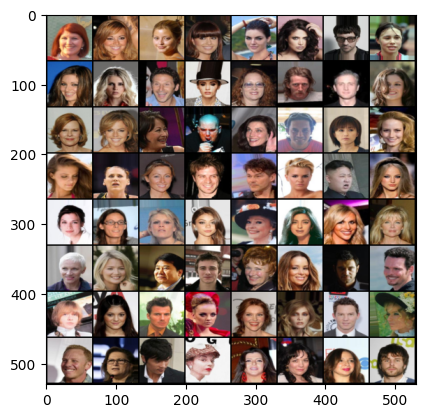

In [ ]:
plt.imshow(np.transpose(vutils.make_grid(real_images[:64], padding=2, normalize=True).cpu(),(1,2,0)))

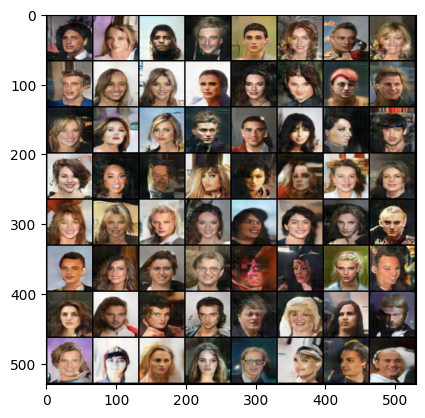

In [ ]:
plt.imshow(np.transpose(vutils.make_grid(fake_images[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Question 3: Please annotate several real and synthetic images using fairface.
Plot the results are there biases within the real images, the synthetic ones ?
Are the biases the same? Why from your opinion?

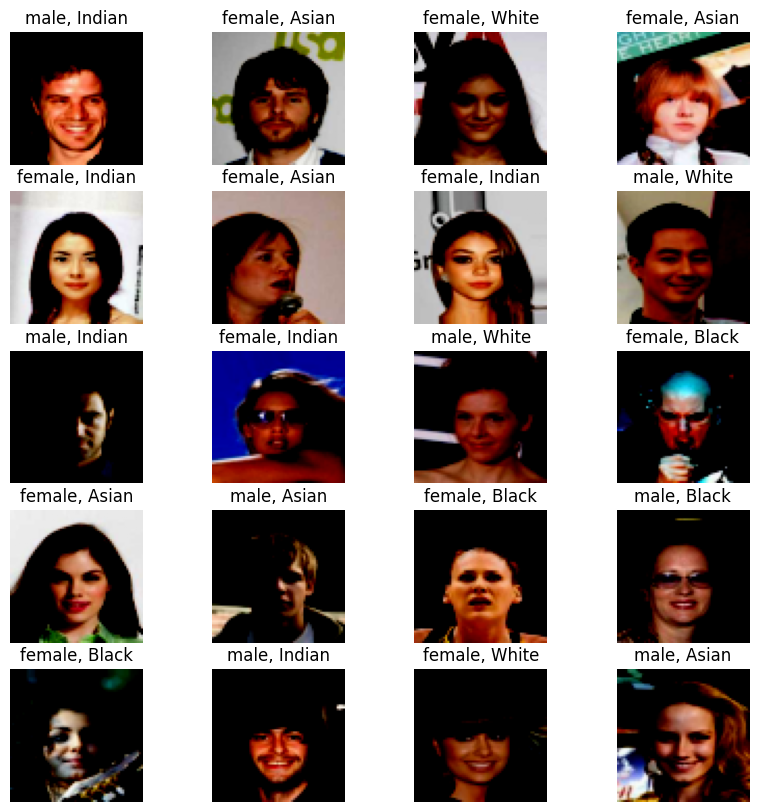

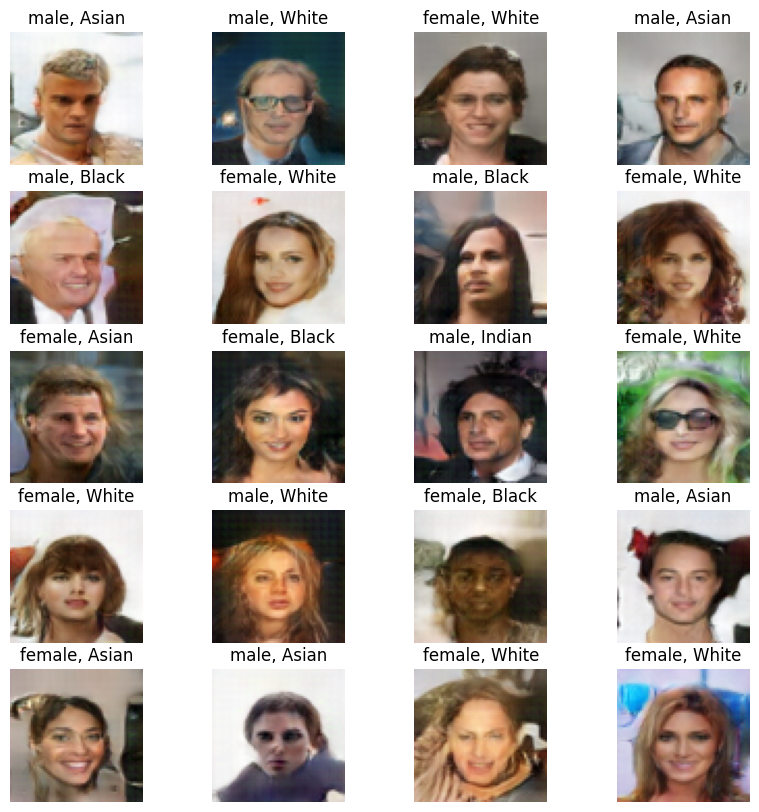

In [ ]:
## TO COMPLETE
# Define the number of images to annotate
num_images_to_annotate = 20  # Adjust as needed

# Randomly select images from real and synthetic sets
annotated_real_images = random.sample(real_images, num_images_to_annotate)
annotated_fake_images = random.sample(fake_images, num_images_to_annotate)

# Annotate images
annotated_results_real = [predict_gender_and_race(img, model_fair_7, model_fair_4) for img in annotated_real_images]
annotated_results_fake = [predict_gender_and_race(img, model_fair_7, model_fair_4) for img in annotated_fake_images]

# Example visualization for a few images
def plot_images(images, annotations):
    plt.figure(figsize=(10,10))
    for i, (img, annotation) in enumerate(zip(images, annotations)):
        # Ensure the tensor is on CPU before plotting
        img = img.cpu()
        plt.subplot(5, 4, i+1)
        # After moving to CPU, you can permute and plot as expected
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"{annotation[0]}, {annotation[1]}")
        plt.axis('off')
    plt.show()

# Visualize annotated real images
plot_images(annotated_real_images, annotated_results_real)

# Visualize annotated synthetic images
plot_images(annotated_fake_images, annotated_results_fake)


Analyzing Biases:

The images generated by the model perform better than race in gender bias. Many characters labeled as black people have white skin.

## DDPM

In [ ]:
#os.chdir("../")

In [ ]:
!wget https://cdn.matix-media.net/dd/c7f76514 -O /content/drive/MyDrive/masterAI.zip


--2024-02-19 18:52:34--  https://cdn.matix-media.net/dd/c7f76514
Resolving cdn.matix-media.net (cdn.matix-media.net)... 104.21.7.52, 172.67.135.197, 2606:4700:3030::6815:734, ...
Connecting to cdn.matix-media.net (cdn.matix-media.net)|104.21.7.52|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdll4TDRzNmVGTEVpUE4zVWVpeC1sOUd2RFRwaWc_ZT14TzRkdHk/root/content [following]
--2024-02-19 18:52:35--  https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdll4TDRzNmVGTEVpUE4zVWVpeC1sOUd2RFRwaWc_ZT14TzRkdHk/root/content
Resolving api.onedrive.com (api.onedrive.com)... 13.107.42.12
Connecting to api.onedrive.com (api.onedrive.com)|13.107.42.12|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://plyvla.db.files.1drv.com/y4mz2IFkZhnOolhQCqU7RZzXydCphHELPK1y01gTYSgrA8BF6OrfXtSEBuSkdKpSK9yTU8ce421ZPKIrVvKb_XuyYTz4WJH5t4NORZzAxp9AVQtAiLb-rA1_VM4W77gBzNbG1B1B

In [ ]:
!unzip -q /content/drive/MyDrive/masterAI.zip && mv masterAI/* ./

In [ ]:
nb_images_to_pick = 200
fake_images_paths = [ os .path.join("/content/FairFaceFolder/ddpm/generated", img) for img in os.listdir("/content/FairFaceFolder/ddpm/generated") ]

rnd_idx = random.sample(list(np.arange(len(fake_images_paths))), nb_images_to_pick)
fake_images_paths = [fake_images_paths[i] for i in rnd_idx]


real_images_paths =  torchvision.datasets.ImageFolder("/content/FairFaceFolder/ffhq/thumbnails128x128")
rnd_idx = random.sample(list(np.arange(len(real_images_paths))), nb_images_to_pick)
real_images_paths = [real_images_paths[i] for i in rnd_idx]

#real_image_paths, real_image_labels = zip(*real_images_paths.imgs)



Question 4: Please annotate several real and synthetic images using fairface. Plot the results are there biases within the real images, the synthetic ones ? Are the biases the same? Why from your opinion?

In [ ]:
# TO COMPLETE

# Preparing the Annotation and Visualization Code

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import torch

def predict_gender_and_race(image, model_gender, model_race):
    # Define your labels before using them
    genders = ["male", "female"]
    races = ['White', 'Black', 'Asian', 'Indian']

    # Assuming image is a PIL Image
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move image to the same device as the model
    device = next(model_gender.parameters()).device
    image = image.to(device)

    # Predict gender and race
    gender_outputs = model_gender(image)
    race_outputs = model_race(image)

    # Example processing (adjust indices and logic as per your model output):
    gender_pred = torch.argmax(torch.softmax(gender_outputs, dim=1), dim=1).item()
    race_pred = torch.argmax(torch.softmax(race_outputs, dim=1), dim=1).item()

    # Ensure predictions are within the expected range
    if gender_pred >= len(genders):
        print(f"Unexpected gender prediction index: {gender_pred}")
        gender_pred = 0  # Default to first gender as fallback

    if race_pred >= len(races):
        print(f"Unexpected race prediction index: {race_pred}")
        race_pred = 0  # Default to first race as fallback

    # Map predictions to your labels
    gender = genders[gender_pred]
    race = races[race_pred]

    return gender, race


In [ ]:
# Loading and Annotating Images

def load_and_annotate_images(image_paths, model_gender, model_race, num_images=20):
    annotated_results = []
    images = []
    for path in random.sample(image_paths, num_images):
        image = Image.open(path).convert("RGB")
        gender, race = predict_gender_and_race(image, model_gender, model_race)
        annotated_results.append((gender, race))
        images.append(image)
    return images, annotated_results


In [ ]:
# Visualizing the Annotated Images
import matplotlib.pyplot as plt

def plot_annotated_images(images, annotations):
    plt.figure(figsize=(10, 10))
    for i, (image, annotation) in enumerate(zip(images, annotations)):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(image)
        ax.set_title(f"{annotation[0]}, {annotation[1]}")
        plt.axis("off")
    plt.show()


Unexpected gender prediction index: 8
Unexpected race prediction index: 8
Unexpected gender prediction index: 8
Unexpected race prediction index: 8
Unexpected gender prediction index: 7
Unexpected gender prediction index: 12
Unexpected gender prediction index: 3
Unexpected gender prediction index: 3
Unexpected race prediction index: 12
Unexpected gender prediction index: 13
Unexpected race prediction index: 8
Unexpected gender prediction index: 7
Unexpected gender prediction index: 12
Unexpected gender prediction index: 7
Unexpected race prediction index: 12
Unexpected gender prediction index: 10
Unexpected gender prediction index: 10
Unexpected gender prediction index: 12
Unexpected gender prediction index: 8
Unexpected gender prediction index: 7
Unexpected race prediction index: 7
Unexpected gender prediction index: 17
Unexpected race prediction index: 17
Unexpected gender prediction index: 3
Unexpected gender prediction index: 8
Unexpected race prediction index: 12
Unexpected gender

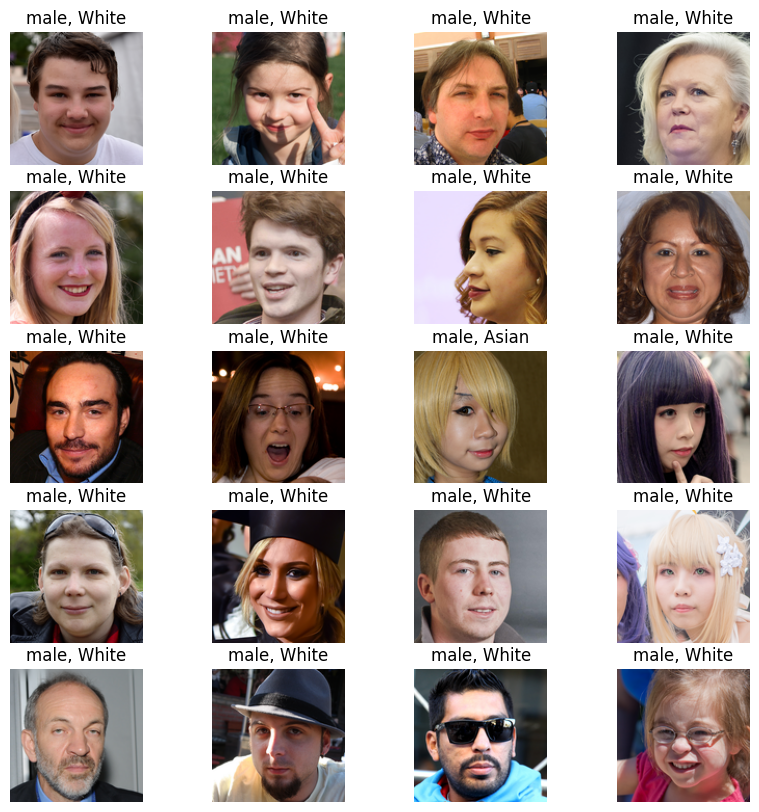

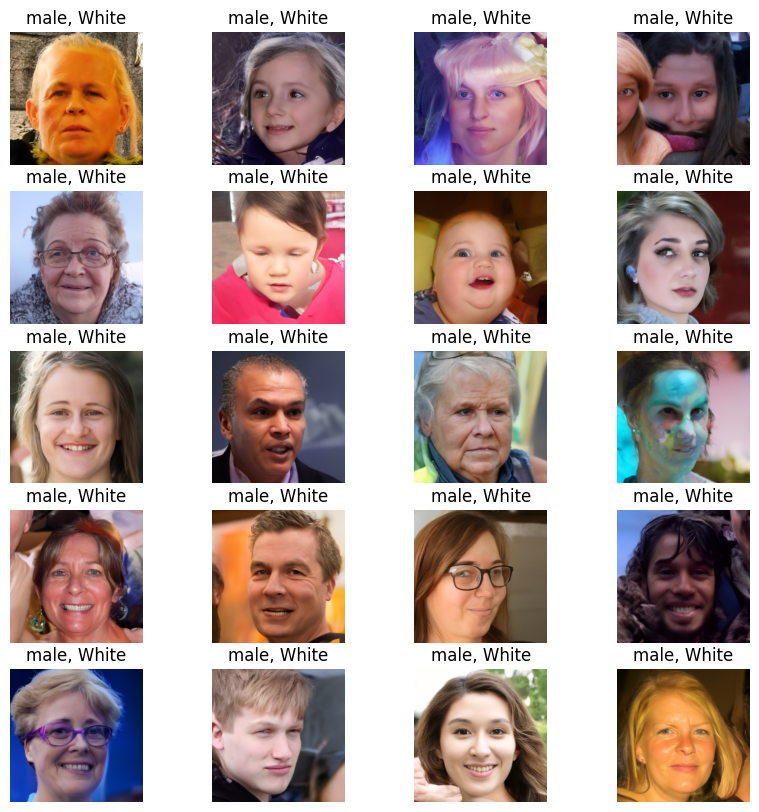

In [ ]:
# analysis

# Assuming fake_images_paths and real_image_paths are correctly defined lists of image paths
num_images_to_annotate = 20

# Load and annotate images
real_images, annotated_real = load_and_annotate_images(real_image_paths, model_fair_7, model_fair_4, num_images_to_annotate)
fake_images, annotated_fake = load_and_annotate_images(fake_images_paths, model_fair_7, model_fair_4, num_images_to_annotate)

# Plot the annotated images
plot_annotated_images(real_images, annotated_real)
plot_annotated_images(fake_images, annotated_fake)


## Using FavCi2D

In [ ]:
#os.chdir("../")

In [ ]:
from collections import OrderedDict
def load_metadata(file_path):
    file = open(file_path, "r")
    file_lines = file.readlines()
    file.close()
    attributes_header = file_lines[0]
    if attributes_header[-1] == "\n":
        attributes_header = attributes_header[:-1]
    attributes_list = attributes_header.split(";")
    attributes_list = [elt.strip() for elt in attributes_list]
    resulting_dict = OrderedDict()
    for attribute in attributes_list:
        resulting_dict[attribute] = []
    for line in file_lines[1:]:
        line:str = line.strip()
        line_attributes = line.split(";")
        for attribute, line_attribute in zip(attributes_list, line_attributes):
            try:
                if int(line_attribute) == float(line_attribute):
                    resulting_dict[attribute].append(int(line_attribute))
                else:
                    resulting_dict[attribute].append(float(line_attribute))
            except Exception as e:
                if line_attribute == "unknown":
                    resulting_dict[attribute].append(-1)
                else:
                    resulting_dict[attribute].append(line_attribute)
    return resulting_dict

In [ ]:
metadata = load_metadata("FAVCID/metadata.txt")
favcid_dict = torch.load("FAVCID/features.pt", map_location="cpu")

In [ ]:
def concatenate_all(dict_, nb_kept_sample = 7000, metadata=None):
    result = [] #None
    demographic_segment = []
    for key in tqdm(dict_.keys()):
        key_metadata_idx = metadata['ID'].index(key)

        key_array = dict_[key].numpy()
        key_array = key_array / np.linalg.norm(key_array, axis = 1).reshape((-1,1))
        if metadata is not None:
            demographic_segment = demographic_segment + [metadata["CONTINENT"][key_metadata_idx] + "-" + metadata["GENDER"][key_metadata_idx] for _ in range(len(key_array))]

        result = result + list(key_array)
    idx_to_keep = random.sample(list(np.arange(len(result))), nb_kept_sample)
    return np.asarray([result[i] for i in idx_to_keep]), np.asarray([demographic_segment[i] for i in idx_to_keep])

In [ ]:
favcid_feats, favcid_segments = concatenate_all(favcid_dict, 2000, metadata)


100%|██████████| 19441/19441 [00:09<00:00, 2003.92it/s]


Question 5: Check that all the norms of the features are equal to one. Prove that L2 distance between two normalized vectors is equivalent to the cosine distance

In [ ]:
# Check the norms
norms = np.linalg.norm(favcid_feats, axis=1)
# Check if all norms are approximately equal to 1
all_norms_one = np.allclose(norms, 1)

In [ ]:
all_norms_one

True

**Proof:**

The L2 distance (Euclidean distance) between two vectors $a$ and $b$ is defined as $\sqrt{\sum(a_i-b_i)^2}$​
 , while the cosine similarity measures the cosine of the angle between two vectors. The cosine distance is $1-cosine$ similarity.

 When two vectors are normalized (i.e., their norms are 1), their L2 distance is related to the cosine similarity. For normalized vectors $a$ and $b$, the square of the L2 distance is: $L2^2=\sum(a_i-b_i)^2=\sum a_i^2 - 2\sum a_ib_i +\sum b_i^2 = 2-2(cosine\,similarity)$.

 Since both vectors are unit vectors, $\sum a_i^2 = \sum b_i^2 =1$, and $\sum a_ib_i$ is the dot product, which for unit vectors equals the cosine of the angle between them. Thus, the L2 distance and cosine similarity (and consequently cosine distance) are directly related for normalized vectors.


Question 6: Do you think we can use PCA (principal composant analysis) in order to visualize the features? What about TSNE (t-distributed stochastic neighbor embedding)  ?

**Answer:**

Both PCA and t-SNE can be used to visualize the features, but they have different strengths:

PCA is faster and can provide a good overview if the most important variances are linear.
t-SNE is better at preserving local structures and can reveal clusters in the data even if they are not separable linearly.


We will here use an alternative to TSNE called UMAP

We want to use the emebeddings of FavCI2D in order to annotate the DDPM and FFHQ images. (You can load the corresponding features of these datasets).


Question : Explain the characteristics of the projection performed by UMAP (you might need to check the documentation). After visualizing the FAVCID data using UMAP, explain which approach you think you can use and which approaches are not adapted from your opinion in order to perform such an annotation.

Implement it

**Answer:**

UMAP works on the principle of manifold learning and fuzzy set theory. It's good at preserving both local and global data structures and is generally faster than t-SNE. It's particularly useful in identifying clusters and patterns in high-dimensional data.

In [ ]:
#!pip uninstall umap
!pip install umap-learn
#import umap
import umap
import matplotlib.pyplot as plt
reducer = umap.UMAP()
projected_embeddings = reducer.fit_transform(favcid_feats)


<ipython-input-64-a885cff0e5bd>:5: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


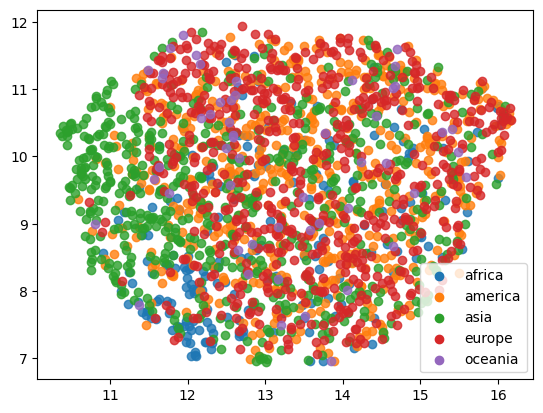

In [ ]:

favcid_origin = np.asarray([elt.split("-")[0] for elt in favcid_segments])
for label in np.unique(favcid_origin):
    plt.scatter(projected_embeddings[favcid_origin == label, 0], projected_embeddings[favcid_origin== label, 1], label = label, alpha=0.8)
leg  =plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)

Question 8: Compare the results your obtain with the one you had with FairFace. Which approach do you think is better and why ?

Question 9: Project DDPM FFHQ FAVCID in 2D using TSNE and UMAP. Are you able to see some shift between datasets? If yes where do you think it can come?
Are you able to identify some clusters within your visualization?

In [ ]:
ddpm_feats = torch.load("/content/FairFaceFolder/ddpm/features.pt", map_location="cpu")
## TO BE COMPLETED
# Extract Feature Vectors:
import numpy as np
import torch

# Assuming ddpm_feats is a dictionary with tensors or arrays as values
features_list = [features.numpy() for features in ddpm_feats.values()]
features_array = np.vstack(features_list)  # Vertically stack the feature arrays to get a 2D array

n_samples, n_features = features_array.shape
print(f"Number of samples: {n_samples}, Number of features: {n_features}")


Number of samples: 10000, Number of features: 512


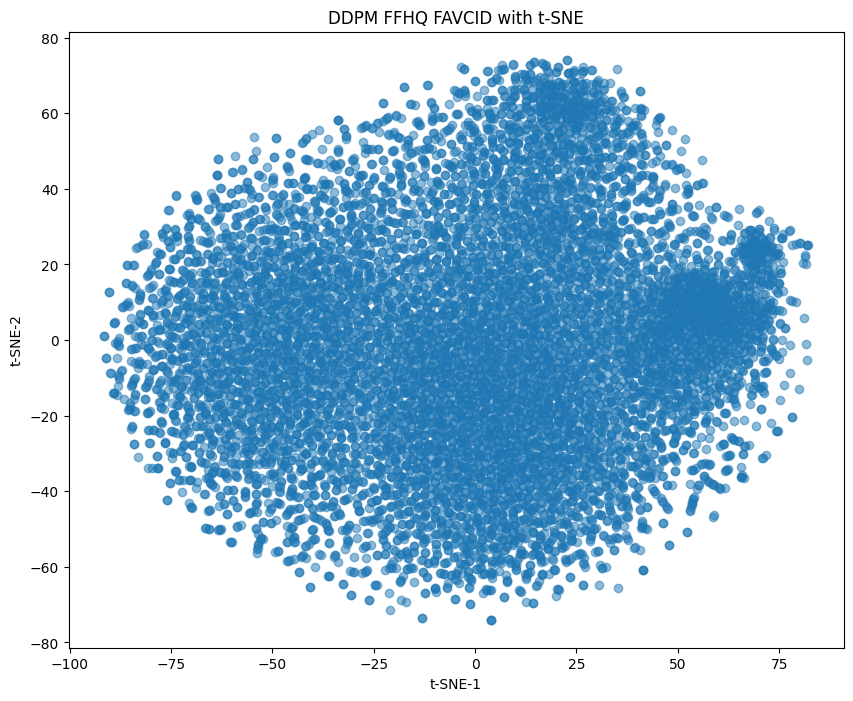

In [ ]:
from sklearn.manifold import TSNE

# Ensure perplexity is valid given the number of samples
perplexity_value = max(5, min(30, n_samples // 5))  # A simple heuristic for example purposes

tsne = TSNE(n_components=2, perplexity=perplexity_value)
ddpm_tsne = tsne.fit_transform(features_array)  # features_array is already 2D here


# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(ddpm_tsne[:, 0], ddpm_tsne[:, 1], alpha=0.5)
plt.title("DDPM FFHQ FAVCID with t-SNE")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()



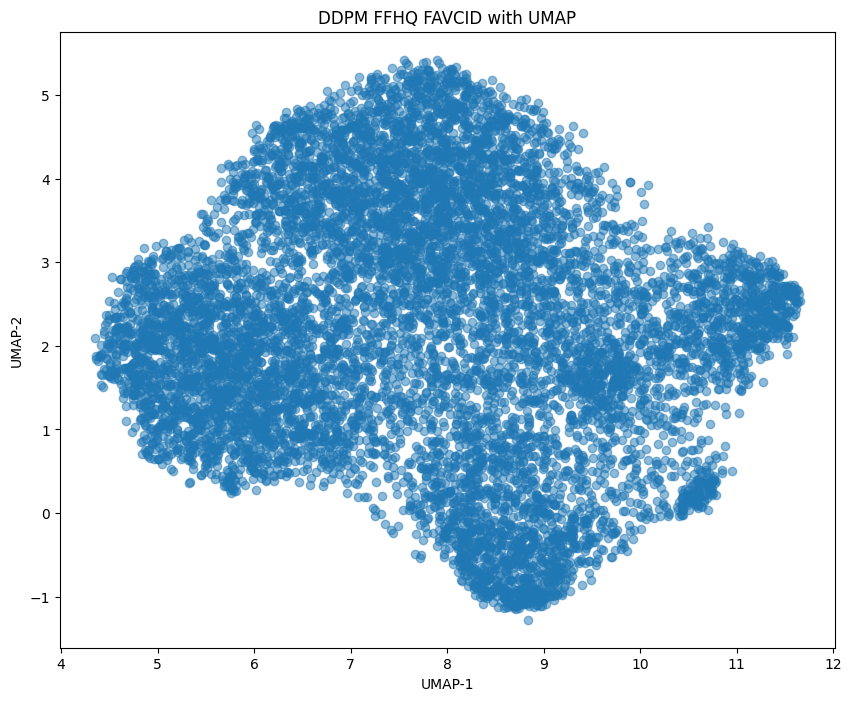

In [ ]:

import umap

reducer = umap.UMAP()
ddpm_umap = reducer.fit_transform(features_array)


# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(ddpm_umap[:, 0], ddpm_umap[:, 1], alpha=0.5)
plt.title("DDPM FFHQ FAVCID with UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


After projecting all datasets (DDPM, FFHQ, FAVCID) using UMAP and t-SNE, compare the clusters and shifts. Differences in clusters or shifts between datasets could indicate variations in data characteristics (like demographic distribution, image quality, etc.). Identifying clusters can reveal underlying patterns or biases in the datasets.

## Evaluating model Performances

the Face Recognition  task consists in guessing wether two pictures represent the same person (identity) or not.
A common way to solve the Face Recognition task is to first train a deep neural network to perform a classification task on faces, we then get rid of the last classification layers. We then use the resulting modelv, whose output are now features vectors, in order to compute distances between images

Two distances files are provided. In these files, each line contains 3 columns. The two first contain the images name that are under this format : <identity>_<img_idx>.png and the last one is the distance between the two pictures in the model embedding space. They correspond to the distances between the FAVCID images obtained while using a model trained on a demographically balanced (WikiDiv) set and an unbalanced set (WikiFamous).

In order to evaluate the models performances we will compute the accuracy metric in a CrossValidation setup.
In order to do so you will compute the accuracy ten times. Each time, ten percent of the dataset is used in order to find a threshold on the distance that separate same identitities to different ones. Then you will compute the accuracy obtained with the previously computed threshold on the remaining 90% distances.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def parse_distance_file(distance_file):
    with open(distance_file, 'r') as file:
        lines = file.readlines()
    image_pairs = []
    distances = []
    for line in lines:
        parts = line.strip().split()
        image_pairs.append((parts[0], parts[1]))
        distances.append(float(parts[2]))
    return np.array(image_pairs), np.array(distances)

def compute_threshold(distances, labels):
    # Simple method: Use median distance as threshold
    # This can be replaced with a more sophisticated method to maximize accuracy
    return np.median(distances)

def compute_model_accuracy(distance_file):
    #TO BE Implemented
    image_pairs, distances = parse_distance_file(distance_file)
    labels = [1 if pair[0].split('_')[0] == pair[1].split('_')[0] else 0 for pair in image_pairs]

    kf = KFold(n_splits=10)
    accuracies = []

    for train_index, test_index in kf.split(distances):
        # Split data
        train_distances, test_distances = distances[train_index], distances[test_index]
        train_labels, test_labels = np.array(labels)[train_index], np.array(labels)[test_index]

        # Compute threshold on the training set
        threshold = compute_threshold(train_distances, train_labels)

        # Predict labels based on threshold
        predictions = [1 if distance <= threshold else 0 for distance in test_distances]

        # Compute accuracy on the test set
        accuracy = accuracy_score(test_labels, predictions)
        accuracies.append(accuracy)

    # Compute mean accuracy across all folds
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Example usage:
distance_file = "path/to/your/distance_file.txt"
model_accuracy = compute_model_accuracy(distance_file)
print("Model Accuracy:", model_accuracy)

Question Do the same but now compute the accuracy for each demographic segment (i.e. each combination of gender/continent)  separately. What can you notice? Which metric could you use to reflect a model's fairness ?